Will follow the tutorial notebook at http://nbviewer.ipython.org/github/BVLC/caffe/blob/dev/examples/net_surgery.ipynb. Therefore we're just manipulating the reference ImageNet model to make it fully-convolutional. Classification map only covers a given input size, in this case 8x8. Translate inner product layers into convolutional layers. 

Had to create the prototxt file for the bvlc_caffenet_full_conv across from the directory of the main net.

In [3]:

!diff /home/alex/Caffe/caffe/examples/imagenet/bvlc_caffenet_full_conv.prototxt /home/alex/Caffe/caffe/models/bvlc_reference_caffenet/deploy.prototxt

1,18c1
< Skip to content
<  This repository
< Explore
< Gist
< Blog
< Help
< @clibbon clibbon
<  
<  Watch 622
<   Star 3,442
<   Fork 2,005
< BVLC/caffe
<  branch: dev  caffe/examples/imagenet/bvlc_caffenet_full_conv.prototxt
< @jeffdonahuejeffdonahue on 5 Feb Upgrade existing nets using upgrade_net_proto_text tool
< 2 contributors @shelhamer @jeffdonahue
< RawBlameHistory    217 lines (216 sloc)  3.027 kb
< # This file is for the net_surgery.ipynb example notebook.
< name: "CaffeNetConv"
---
> name: "CaffeNet"
20c3
< input_dim: 1
---
> input_dim: 10
22,23c5,6
< input_dim: 451
< input_dim: 451
---
> input_dim: 227
> input_dim: 227
168,169c151,152
<   name: "fc6-conv"
<   type: "Convolution"
---
>   name: "fc6"
>   type: "InnerProduct"
171,172c154,155
<   top: "fc6-conv"
<   convolution_param {
---
>   top: "fc6"
>   inner_product_param {
174d156
<     kernel_size: 6
180,181c162,163
<   bottom: "fc6-conv"
<   top: "fc6-conv"
---
>   bottom: "fc6"
>   top: "fc6"
186,187c168,169
<   bott

Need to change the full-connected classifier ip layer to a convolutional layer with a 6x6 filter - so fit in with the other models input to the pool 5 layer. 

In [2]:
caffe_root = '/home/alex/Caffe/caffe/'
import sys
sys.path.insert(0, caffe_root + 'python')
import caffe
net = caffe.Net(caffe_root + '/models/bvlc_reference_caffenet/deploy.prototxt', 
                caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel', 
                caffe.TEST)
params = ['fc6', 'fc7', 'fc8']
#fc_params = {name: (weights, biases)}
fc_params = {pr: (net.params[pr][0].data, net.params[pr][1].data) 
             for pr in params}

for fc in params:
    print '{} weights are {} dimnesional and biases are \
{} dimensional'.format(fc, fc_params[fc][0].shape, 
                       fc_params[fc][1].shape)

fc6 weights are (4096, 9216) dimnesional and biases are (4096,) dimensional
fc7 weights are (4096, 4096) dimnesional and biases are (4096,) dimensional
fc8 weights are (1000, 4096) dimnesional and biases are (1000,) dimensional


For weights the 0th and 1st dimensions are 1 for both. Second and third for weights are input sizes and biases last is output size.

In [3]:
# Load the fully-convolutional network to transplant the parameters.
net_full_conv = caffe.Net(caffe_root + 'examples/imagenet/bvlc_caffenet_full_conv.prototxt', 
                          caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel',
                          caffe.TEST)
params_full_conv = ['fc6-conv', 'fc7-conv', 'fc8-conv']
# conv_params = {name: (weights, biases)}
conv_params = {pr: (net_full_conv.params[pr][0].data, net_full_conv.params[pr][1].data) for pr in params_full_conv}

for conv in params_full_conv:
    print '{} weights are {} dimensional and biases are {} dimensional'.format(conv, conv_params[conv][0].shape, conv_params[conv][1].shape)

fc6-conv weights are (4096, 256, 6, 6) dimensional and biases are (4096,) dimensional
fc7-conv weights are (4096, 4096, 1, 1) dimensional and biases are (4096,) dimensional
fc8-conv weights are (1000, 4096, 1, 1) dimensional and biases are (1000,) dimensional


In [4]:
# The zip function takes the ith element from both and combines them into a tuple
for pr, pr_conv in zip(params, params_full_conv):
    conv_params[pr_conv][1][...] = fc_params[pr][1]

The output channels have leading dimnesion of the inner product and the convolution weights, so translate by reshaping the flat input dimnesional parameter vector to the new filter shape

In [5]:
for pr, pr_conv in zip(params, params_full_conv):
    out, in_, h, w = conv_params[pr_conv][0].shape
    W = fc_params[pr][0].reshape((out, in_, h, w))
    conv_params[pr_conv][0][...] = W

Save the model weights

In [6]:
net_full_conv.save(caffe_root + 'examples/imagenet/bvlc_caffenet_full_conv.caffemodel')

[[282 282 281 281 281 281 277 282]
 [281 283 283 281 281 281 281 282]
 [283 283 283 283 283 283 287 282]
 [283 283 283 281 283 283 283 259]
 [283 283 283 283 283 283 283 259]
 [283 283 283 283 283 283 259 259]
 [283 283 283 283 259 259 259 277]
 [335 335 283 259 263 263 263 277]]


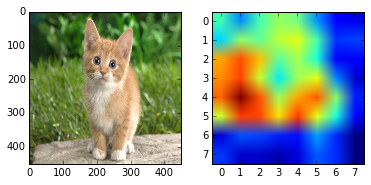

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocessing
im = caffe.io.load_image(caffe_root + 'examples/images/cat.jpg')
transformer = caffe.io.Transformer({'data': net_full_conv.blobs['data'].
                                    data.shape})
transformer.set_mean('data',np.load(caffe_root + 'python/caffe/imagenet/'
                                  + 'ilsvrc_2012_mean.npy').mean(1).mean(1))
transformer.set_transpose('data', (2,0,1))
transformer.set_channel_swap('data', (2,1,0))
transformer.set_raw_scale('data', 255.0)
# make classification map by forward and print prediction indices at each location
out = net_full_conv.forward_all(data=np.asarray([transformer.preprocess('data', im)]))
print out['prob'][0].argmax(axis=0)
# show net input and confidence map (probability of the top prediction at each location)
plt.subplot(1, 2, 1)
plt.imshow(transformer.deprocess('data', net_full_conv.blobs['data'].data[0]))
plt.subplot(1, 2, 2)
plt.imshow(out['prob'][0].max(axis=0))